Relevant functions

In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

In [2]:
Xop=sp.sparse.csr_array([[0.,1.],[1.,0.]]) # Pauli X
Yop=sp.sparse.csr_array([[0,-1j],[1j,0.]])
Zop=sp.sparse.csr_array([[1.,0.],[0.,-1]])

In [3]:
def operator(op,idx,N):
  """
  Produce an operator that has single-qubit operator op acting
  on qubit with index idx, and the rest is identity. N is the total number of qubits.
  idx count starts at 0 and runs up to N-1.

  Example: Z_3
  >> operator(Zop,3,10)

  Example: X_0 X_2
  >>  operator(Xop,0,10) @ operator(Xop,2,10)
  """
  return sp.sparse.kron( sp.sparse.identity(2**idx), sp.sparse.kron(op, sp.sparse.identity(2**(N-idx-1))) )

def expectation(psi,op):
  """
  Calculate the expectation value of observable operator op with respect to state psi.
  This takes the real part automatically, assuming op is Hermitean !
  """

  return np.real( np.sum( np.conj(psi) * (op @ psi) ) )

def empty_matrix(n_dim):
  """
  Return the empty sparse matrix for a system of Hilbert space dimension n_dim.
  """
  return sp.sparse.csr_matrix((n_dim, n_dim), dtype='complex')

def produce_XYZ(N):
  """
  Return X,Y,Z = a list of all Pauli X operators, all Pauli Y, all Pauli Z,
  for given qubit number N
  """
  return ( [operator(Xop,idx,N) for idx in range(N)] ,
            [operator(Yop,idx,N) for idx in range(N)] ,
            [operator(Zop,idx,N) for idx in range(N)] )

def ground_state(H):
  """
  Return ground state of H, using sparse Lanczos.
  Returns eigenvalue, eigenvector
  """
  evals,evecs=sp.sparse.linalg.eigsh(H, k=1, which='SA')
  return evals[0], evecs[:,0]


System dimensions

In [4]:
# generate all the single-qubit operators:
N = 10 # qubit number
X,Y,Z = produce_XYZ(N)

Hamiltonian (OBC to mostly avoid steps and discontinuities; also closer to experiments)

In [5]:
## example:

H_theta_terms = [
  sum([X[j] for j in range(0,N)]),
  sum([Z[j] @ Z[j+1] for j in range(0,N-1)])
  ]

g_ZXZ = .5
H_const = g_ZXZ * sum([Z[j] @ X[(j+1)%N] @ Z[(j+2)%N] for j in range(1,N-2)]) ## topological term

H_out = [X[0] @ X[4]]


def HamiltonianPhase(theta, H_theta_terms, H_out, out_coupl):
  """
  Construct a QEP Hamiltonian from the given components.

  H0 - untrainable terms in Hamiltonian

  H0_terms - terms for the untrainable part of the Hamiltonian
  theta_0 - parameters that define the phase diagram, untrainable

  theta - a vector (list or array) of trainable parameters
  H_theta_terms - a list of corresponding terms in the Hamiltonian

  Returns the Hamiltonian H as a sum of all these terms.
  """

  H = sp.sparse.csr_matrix((2**N, 2**N))

  ## trained part of Hamiltonian
  for jj in range(0,len(theta)):
    H += theta[jj] * H_theta_terms[jj]
  
  ## output part of Hamiltonian
  for jj in range(0,len(out_coupl)):
    H += out_coupl[jj] * H_out[jj]
  
  ## fixed constant term
  H += H_const

  return -H

In [6]:
## maximizes derivative
def cost_func(theta, H_theta_terms, H_out, out_coupl):
    _, eigVect_1 = ground_state(HamiltonianPhase(theta, H_theta_terms, H_out, out_coupl))
    return - np.abs(sum(expectation(eigVect_1, H_out[jj]) for jj in range(0,len(out_coupl))))

In [7]:
def get_gradient(theta, H_theta_terms, H_out, out_coupl, nudge):

    _, eigVect = ground_state(HamiltonianPhase(theta, H_theta_terms, H_out, out_coupl))

    expect_sign = np.array([np.sign(expectation(eigVect, H_out[jj])) for jj in range(0,len(H_out))])
    
    _, eigVect_nudge = ground_state(HamiltonianPhase(theta, H_theta_terms, H_out, out_coupl + np.array([nudge])))

    diff_theta = np.array([[expect_sign[0] * (expectation(eigVect_nudge, H_theta_terms[jj]) - expectation(eigVect, H_theta_terms[jj]))/nudge] for jj in range(0,len(H_theta_terms))])

    gradient_norm = np.linalg.norm(diff_theta)

    return - diff_theta / gradient_norm

Training

two runs: run1 and run2 for two different initial points

depending on the run, choose theta_start below accordingly

In [93]:
## initialise randomly
theta_start = np.random.randn(len(H_theta_terms))

In [147]:
theta_start = np.array([-.1, .4]) ## theta_1 (run 1)

In [157]:
theta_start = np.array([0.2, .9]) ## theta_2 (run 2)

In [158]:
## initialise
theta = theta_start

## learning rate
learning_rate = 1e-1

## number of total runs
number_epochs = 100

## iterations
number_iterations = number_epochs #int(number_epochs * len(x_train) / batch_size)

## coupling to output operator (when not in nudge phase)
out_coupl = [0.0]

## nudge parameter scaling eta (uses eta * error_signal)
#nudge = 3*1e-1
nudge = 1e-1

In [159]:
cost_func_list = np.array([])

learning_rate_decay = 0.0
epoch = 0

theta_list = np.array([])

learning_rate_t = learning_rate

for jj in range(0,number_iterations):
    tmp_grad = get_gradient(theta, H_theta_terms, H_out, out_coupl, nudge)
    tmp_cost_func = cost_func(theta, H_theta_terms, H_out, out_coupl)

    ## learning rate decay
    #learning_rate_t = learning_rate * 1 / (1 + learning_rate_decay * epoch)
    #epoch += 1

    theta_list = np.append(theta_list, theta)
    cost_func_list = np.append(cost_func_list, tmp_cost_func)

    theta -= learning_rate_t * tmp_grad.flatten()

theta_list = np.append(theta_list, theta)
cost_func_list = np.append(cost_func_list, tmp_cost_func)

In [151]:
import os
cwd = os.getcwd()
os.chdir("./run 2 (closer to origin)") # <-- replace with relevant file directory and choose folders 'run1' or 'run2' according to the run that is executed.

In [152]:
np.savetxt("cost_func_list_OBC_run_1.csv", cost_func_list, delimiter=",") # evaluate the command according to the run that is executed (for run2, see below)

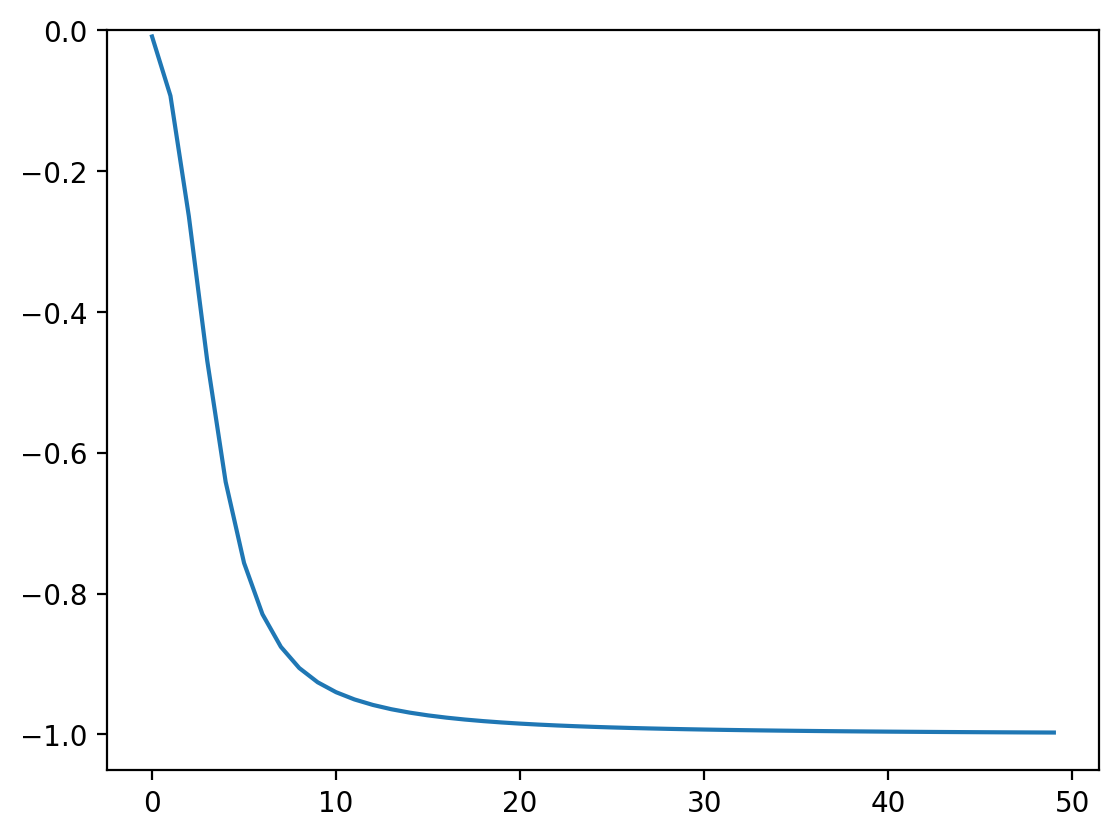

In [156]:
plt.plot(cost_func_list[:50])
plt.ylim([-1.05,0.0])

plt.savefig('cost_function_run_1.pdf') # evaluate the command according to the run that is executed (for run2, see below)

In [160]:
np.savetxt("cost_func_list_OBC_run_2.csv", cost_func_list, delimiter=",") # evaluate the command according to the run that is executed (for run1, see above)

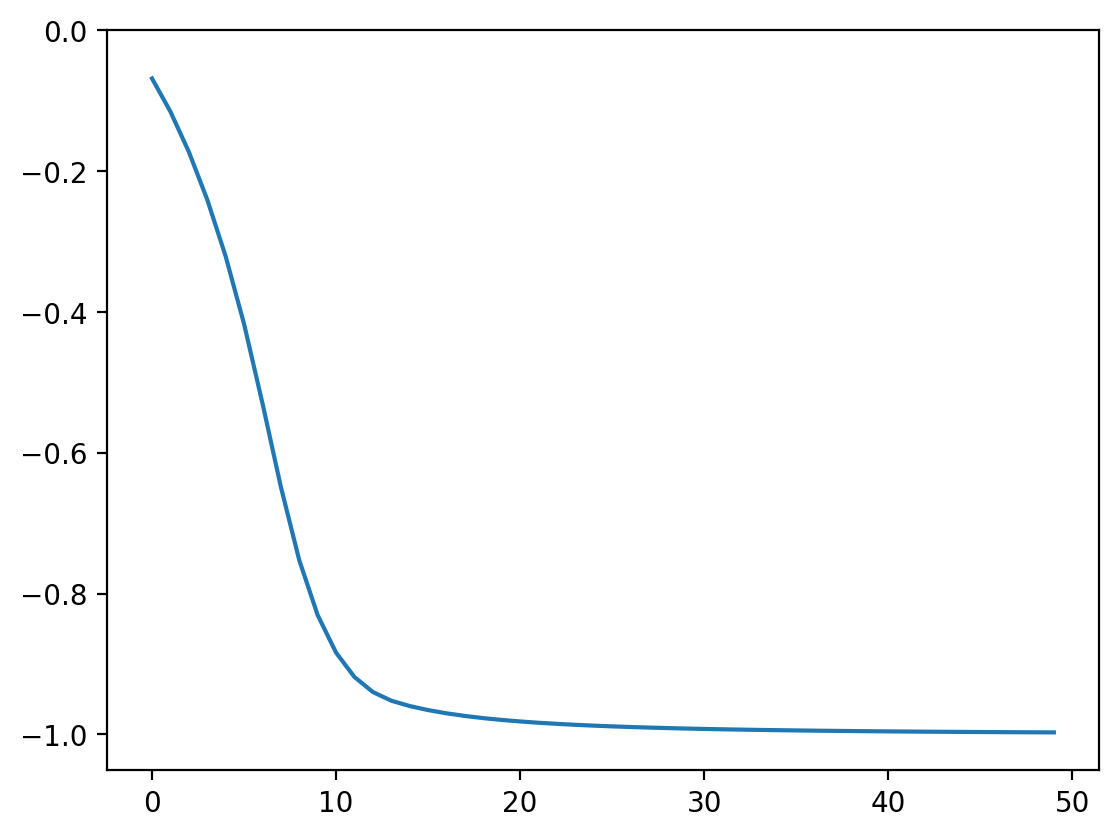

In [161]:
plt.plot(cost_func_list[:50])
plt.ylim([-1.05,0.0])

plt.savefig('cost_function_run2.pdf') # evaluate the command according to the run that is executed (for run1, see above)

Phase diagram sweep

In [17]:
def phase_diagram_2D_sweep(op, h_min, h_max, sweep1, sweep2, theta, out_coupl, resolution):
    tmp = np.zeros((resolution,resolution))
    theta_sweep = theta
    for jj in range(0,resolution):
        for ll in range(0,resolution):
            h1 = h_min + jj * (h_max - h_min)/resolution
            h2 = h_min + ll * (h_max - h_min)/resolution
            theta_sweep[sweep1] = h1
            theta_sweep[sweep2] = h2
            _, eigVect = ground_state(HamiltonianPhase(theta_sweep,H_theta_terms, H_out, out_coupl))
            tmp[ll,jj] = expectation(eigVect, op)
    return tmp

In [98]:
## sweep parameters of X[j] term and Z[j] @ Z[j+1] terms
phase_diag_slice = phase_diagram_2D_sweep(H_out[0], -2.01, 2, 0, 1, np.array([0.0, 0.0]), out_coupl, 100)

In [100]:
## sweep parameters of X[j] term and Z[j] @ Z[j+1] terms
phase_diag_slice_zoomIn = phase_diagram_2D_sweep(H_out[0], -1.01, 0, 0, 1, np.array([0.0, 0.0]), out_coupl, 100)

In [139]:
theta_list = theta_list.reshape((number_epochs+1,len(theta)))

In [46]:
theta_list_run_1 = theta_list ## run 1

In [58]:
theta_list_run_2 = theta_list ## run 2

In [69]:
red_color_list = [[x, 0, 0, 1.0] for x in np.arange(0.0,1,1/len(theta_list))]
blue_color_list = [[0, 0, x, 1.0] for x in np.arange(0.0,1,1/len(theta_list))]

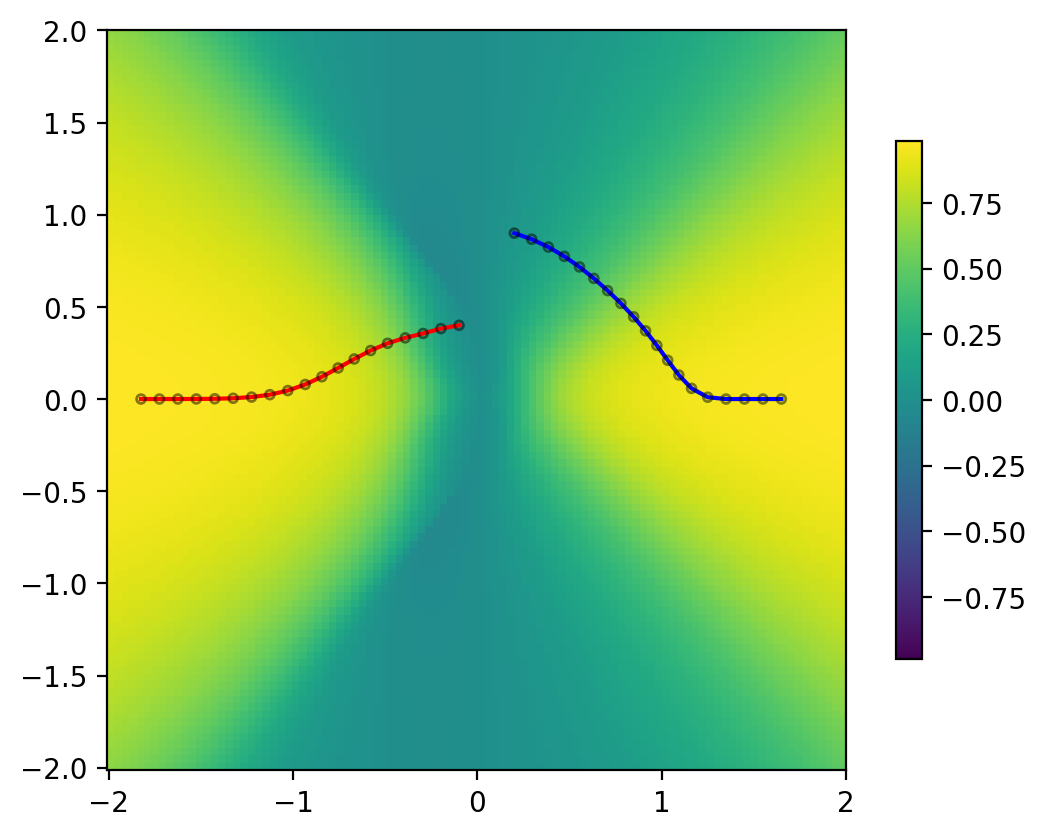

In [134]:
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

plt.imshow(phase_diag_slice, extent = [-2.01, 2.0, -2.01, 2.0],origin='lower',norm=colors.CenteredNorm())
plt.colorbar(shrink = .7)

max_iter = 19

plt.plot(theta_list_run_1[:max_iter,0], theta_list_run_1[:max_iter,1], c='r', zorder=0)
plt.scatter(theta_list_run_1[:max_iter,0], theta_list_run_1[:max_iter,1], facecolors='none', edgecolors=red_color_list, s=10, zorder=1, alpha=0.5)

plt.plot(theta_list_run_2[:max_iter,0], theta_list_run_2[:max_iter,1], c='b', zorder=0)
plt.scatter(theta_list_run_2[:max_iter,0], theta_list_run_2[:max_iter,1], facecolors='none', edgecolors=blue_color_list, s=10, zorder=1, alpha=0.5)

plt.savefig('walk_in_phase_diag_2.pdf')

In [105]:
np.savetxt("theta_list_run_1.csv", theta_list_run_1, delimiter=",")
np.savetxt("theta_list_run_2.csv", theta_list_run_2, delimiter=",")
np.savetxt("phase_diag_slice_OBC.csv", phase_diag_slice, delimiter=",")
np.savetxt("phase_diag_slice_zoomIn_OBC.csv", phase_diag_slice_zoomIn, delimiter=",")